# Week 4 — Pit Strategy Optimizer (Project #3)

This notebook builds a simple F1-style pit strategy optimizer.
It uses tire degradation models (from Week 3) to simulate race time
for different pit laps and tire choices, then selects the fastest strategy.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:


import os
import sys

project_path = "/content/drive/MyDrive/F1-Strategy-Lab"
src_path = os.path.join(project_path, "src")

print("SRC PATH:", src_path)
print("SRC EXISTS:", os.path.exists(src_path))
print("SRC FILES:", os.listdir(src_path))

# Force-add src directory
if src_path not in sys.path:
    sys.path.insert(0, src_path)

print("sys.path[0]:", sys.path[0])

from strategy import fit_linear_degradation, DegradationModel, StrategyPlan
print("strategy.py imported successfully ✅")


SRC PATH: /content/drive/MyDrive/F1-Strategy-Lab/src
SRC EXISTS: True
SRC FILES: ['data_download.py', 'New Text Document.txt', '__pycache__', 'strategy.py']
sys.path[0]: /content/drive/MyDrive/F1-Strategy-Lab/src
strategy.py imported successfully ✅


## One-Stop Race Simulation

We simulate a full race using linear tire degradation models.
A strategy is defined by:
- pit lap
- starting compound
- second compound


In [ ]:


import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Project paths
PROJECT_PATH = "/content/drive/MyDrive/F1-Strategy-Lab"
DATA_PATH = os.path.join(PROJECT_PATH, "data")
SRC_PATH = os.path.join(PROJECT_PATH, "src")

# Make src importable
if SRC_PATH not in sys.path:
    sys.path.insert(0, SRC_PATH)

# Sanity checks
print("PROJECT_PATH exists:", os.path.exists(PROJECT_PATH))
print("DATA_PATH exists:", os.path.exists(DATA_PATH))
print("SRC_PATH exists:", os.path.exists(SRC_PATH))
print("SRC files:", os.listdir(SRC_PATH))


PROJECT_PATH exists: True
DATA_PATH exists: True
SRC_PATH exists: True
SRC files: ['data_download.py', 'New Text Document.txt', '__pycache__', 'strategy.py']


In [ ]:


from strategy import (
    fit_linear_degradation,
    simulate_one_stop_race,
    DegradationModel,
    StrategyPlan
)

print("Project modules imported successfully ✅")


Project modules imported successfully ✅


In [ ]:

race_year = 2024
race_name = "bahrain_grand_prix"
driver_code = "VER"

laps_file = f"{DATA_PATH}/{race_year}/{race_name}/laps_{race_year}_{race_name}.csv"
laps = pd.read_csv(laps_file)

def prepare_laps(df):
    def to_seconds(laptime_str):
        if isinstance(laptime_str, float) or laptime_str is None:
            return np.nan
        parts = str(laptime_str).split()[-1]
        minutes = int(parts.split(":")[1])
        seconds = float(parts.split(":")[2])
        return minutes * 60 + seconds

    df = df.copy()
    df["LapTimeSeconds"] = df["LapTime"].apply(to_seconds)

    if {"PitOutTime", "PitInTime"}.issubset(df.columns):
        df = df[df["PitOutTime"].isna() & df["PitInTime"].isna()]

    df = df[df["LapTimeSeconds"].notna()]
    median = df["LapTimeSeconds"].median()
    df = df[df["LapTimeSeconds"] < median * 1.15]

    if "TyreLife" not in df.columns or df["TyreLife"].isna().all():
        df["TyreLife"] = df.groupby(["Driver", "Stint"]).cumcount() + 1

    return df.reset_index(drop=True)

clean_laps = prepare_laps(laps)

TOTAL_LAPS = int(clean_laps["LapNumber"].max())

print("Total race laps:", TOTAL_LAPS)
clean_laps.head()


Total race laps: 57


,Time,Driver,DriverNumber,LapTime,LapNumber,Stint,PitOutTime,PitInTime,Sector1Time,Sector2Time,...,Team,LapStartTime,LapStartDate,TrackStatus,Position,Deleted,DeletedReason,FastF1Generated,IsAccurate,LapTimeSeconds
0,0 days 01:01:37.489000,VER,1,0 days 00:01:37.284000,1.0,1.0,NaN,NaN,NaN,0 days 00:00:41.266000,...,Red Bull Racing,0 days 00:59:59.911000,2024-03-02 15:03:42.342,12,1.0,False,NaN,False,False,97.284
1,0 days 01:03:13.785000,VER,1,0 days 00:01:36.296000,2.0,1.0,NaN,NaN,0 days 00:00:30.916000,0 days 00:00:41.661000,...,Red Bull Racing,0 days 01:01:37.489000,2024-03-02 15:05:19.920,1,1.0,False,NaN,False,True,96.296
2,0 days 01:04:50.538000,VER,1,0 days 00:01:36.753000,3.0,1.0,NaN,NaN,0 days 00:00:30.999000,0 days 00:00:41.966000,...,Red Bull Racing,0 days 01:03:13.785000,2024-03-02 15:06:56.216,1,1.0,False,NaN,False,True,96.753
3,0 days 01:06:27.185000,VER,1,0 days 00:01:36.647000,4.0,1.0,NaN,NaN,0 days 00:00:30.931000,0 days 00:00:41.892000,...,Red Bull Racing,0 days 01:04:50.538000,2024-03-02 15:08:32.969,1,1.0,False,NaN,False,True,96.647
4,0 days 01:08:04.358000,VER,1,0 days 00:01:37.173000,5.0,1.0,NaN,NaN,0 days 00:00:31.255000,0 days 00:00:42.056000,...,Red Bull Racing,0 days 01:06:27.185000,2024-03-02 15:10:09.616,1,1.0,False,NaN,False,True,97.173


In [ ]:
models = fit_linear_degradation(clean_laps, driver_code)

models


{'SOFT': DegradationModel(intercept=95.30024412704378, slope=0.039097851281087594),
 'HARD': DegradationModel(intercept=94.94143825249398, slope=0.06081011351909177)}

In [ ]:
pit_lap = 18

total_time, lap_times, compounds = simulate_one_stop_race(
    total_laps=TOTAL_LAPS,
    pit_lap=pit_lap,
    first_compound="SOFT",
    second_compound="HARD",
    degradation_models=models,
    pit_loss=22.0
)

print(f"Total race time: {total_time:.1f} s")


Total race time: 5494.2 s


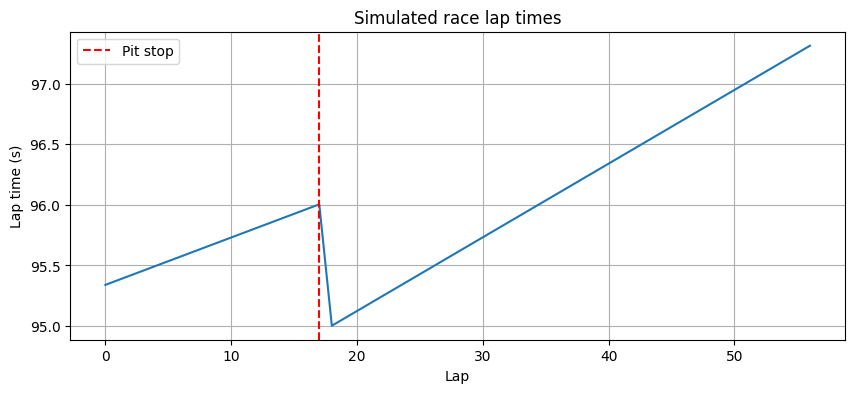

In [ ]:
plt.figure(figsize=(10, 4))
plt.plot(lap_times)
plt.axvline(pit_lap - 1, color="red", linestyle="--", label="Pit stop")
plt.xlabel("Lap")
plt.ylabel("Lap time (s)")
plt.title("Simulated race lap times")
plt.legend()
plt.grid(True)
plt.show()


## Strategy Optimization

We brute-force all reasonable one-stop strategies by varying:
- pit lap
- starting compound
- second compound

The objective is to minimize total race time.


In [ ]:
from strategy import StrategyPlan

pit_window = range(10, TOTAL_LAPS - 10)   # realistic pit window
compounds = list(models.keys())

results = []

for first in compounds:
    for second in compounds:
        if first == second:
            continue  # skip same compound strategies

        for pit_lap in pit_window:
            total_time, _, _ = simulate_one_stop_race(
                total_laps=TOTAL_LAPS,
                pit_lap=pit_lap,
                first_compound=first,
                second_compound=second,
                degradation_models=models,
                pit_loss=22.0
            )

            results.append(
                StrategyPlan(
                    first_compound=first,
                    second_compound=second,
                    pit_lap=pit_lap,
                    total_time=total_time
                )
            )
results_sorted = sorted(results, key=lambda s: s.total_time)

top_5 = results_sorted[:5]

for i, strat in enumerate(top_5, 1):
    print(
        f"{i}. {strat.first_compound} → {strat.second_compound}, "
        f"pit lap {strat.pit_lap}, "
        f"time = {strat.total_time:.1f} s"
    )


1. SOFT → HARD, pit lap 31, time = 5485.5 s
2. HARD → SOFT, pit lap 26, time = 5485.5 s
3. SOFT → HARD, pit lap 32, time = 5485.6 s
4. HARD → SOFT, pit lap 25, time = 5485.6 s
5. HARD → SOFT, pit lap 27, time = 5485.6 s


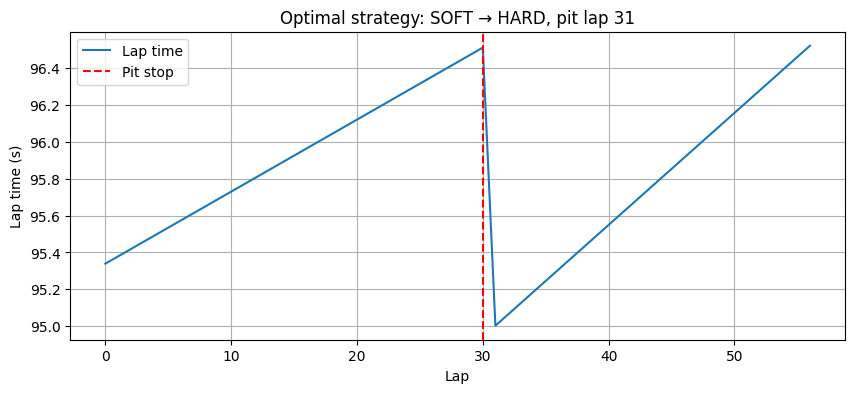

In [ ]:
best = top_5[0]

best_time, best_laps, best_compounds = simulate_one_stop_race(
    total_laps=TOTAL_LAPS,
    pit_lap=best.pit_lap,
    first_compound=best.first_compound,
    second_compound=best.second_compound,
    degradation_models=models,
    pit_loss=22.0
)

plt.figure(figsize=(10, 4))
plt.plot(best_laps, label="Lap time")
plt.axvline(best.pit_lap - 1, color="red", linestyle="--", label="Pit stop")
plt.xlabel("Lap")
plt.ylabel("Lap time (s)")
plt.title(
    f"Optimal strategy: {best.first_compound} → {best.second_compound}, "
    f"pit lap {best.pit_lap}"
)
plt.legend()
plt.grid(True)
plt.show()
